<a href="https://colab.research.google.com/github/Azaidi317/Segmentation-SAM/blob/main/Distortion_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== Surround View Camera Distortion Comparison ===
This notebook analyzes and compares distortion patterns between two
surround view camera images taken from different mounting locations.
Please upload two images from surround view cameras mounted at different locations:


Saving image (171).png to image (171) (1).png
Saving image (172).png to image (172).png
Successfully uploaded: image (171) (1).png and image (172).png
Loaded images: image (171) (1).png and image (172).png
Resizing images: Image 1 (1920x1536), Image 2 (1047x824)
Resizing images: Image 1 (1920x1536), Image 2 (1047x824)
Checking for calibration pattern...
No calibration pattern detected in at least one image, skipping reprojection error...
Estimating distortion using gradient analysis...
Calculating radial distortion metrics...
Calculating similarity metrics...
Creating visualizations...


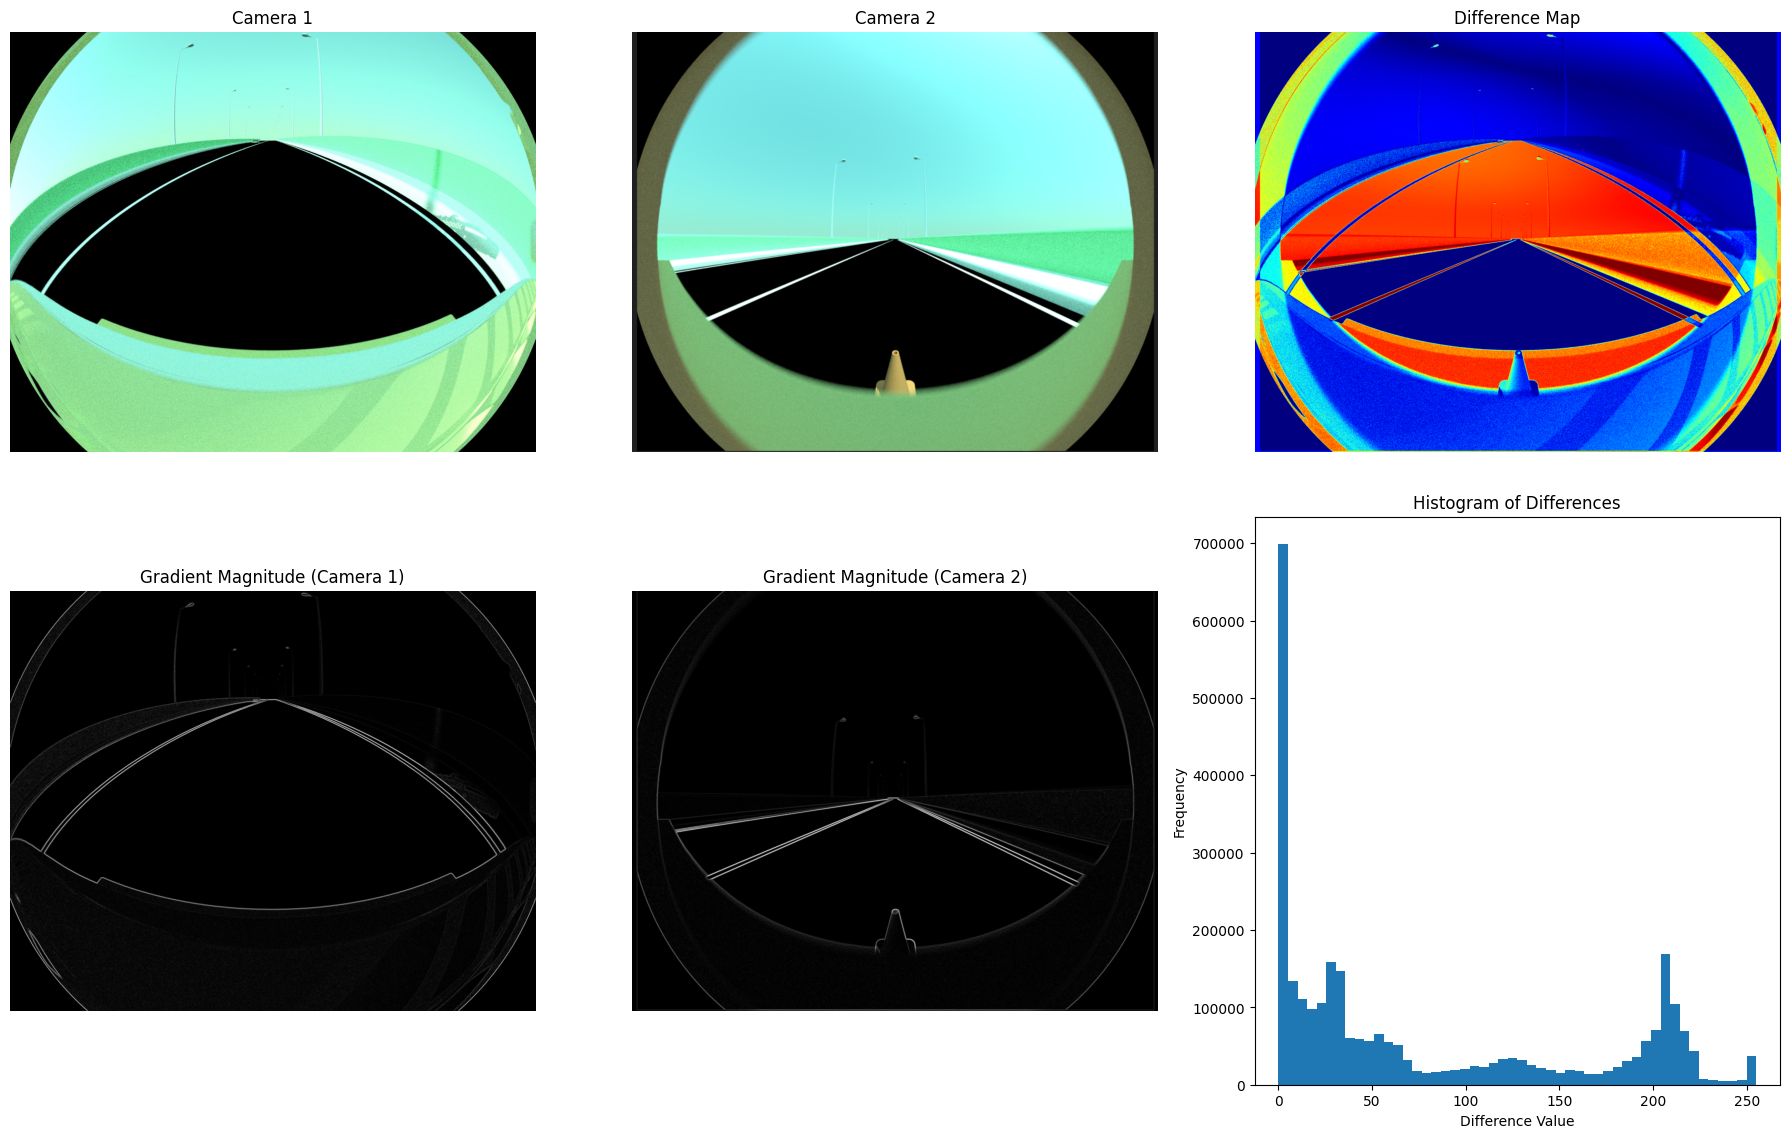

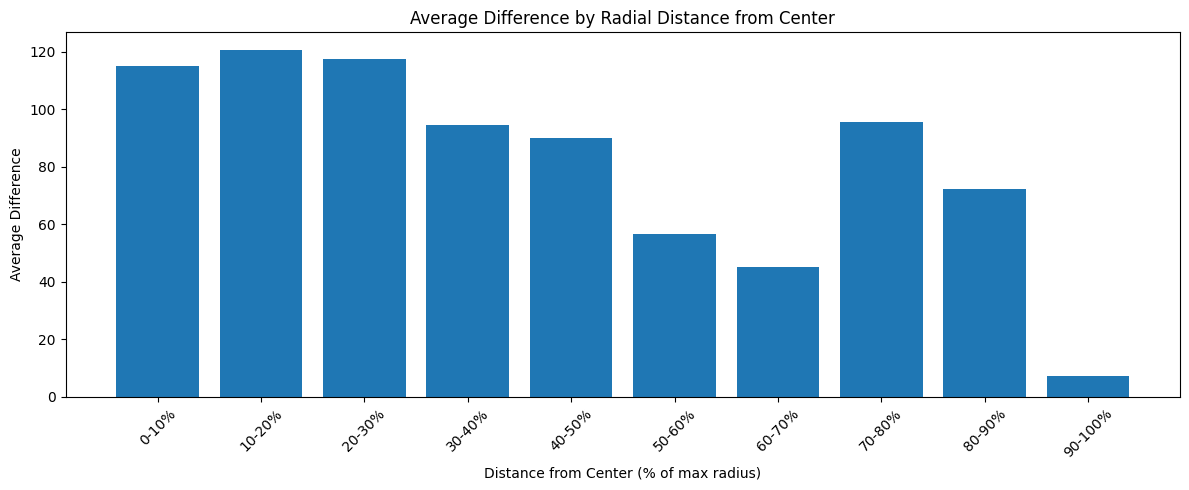

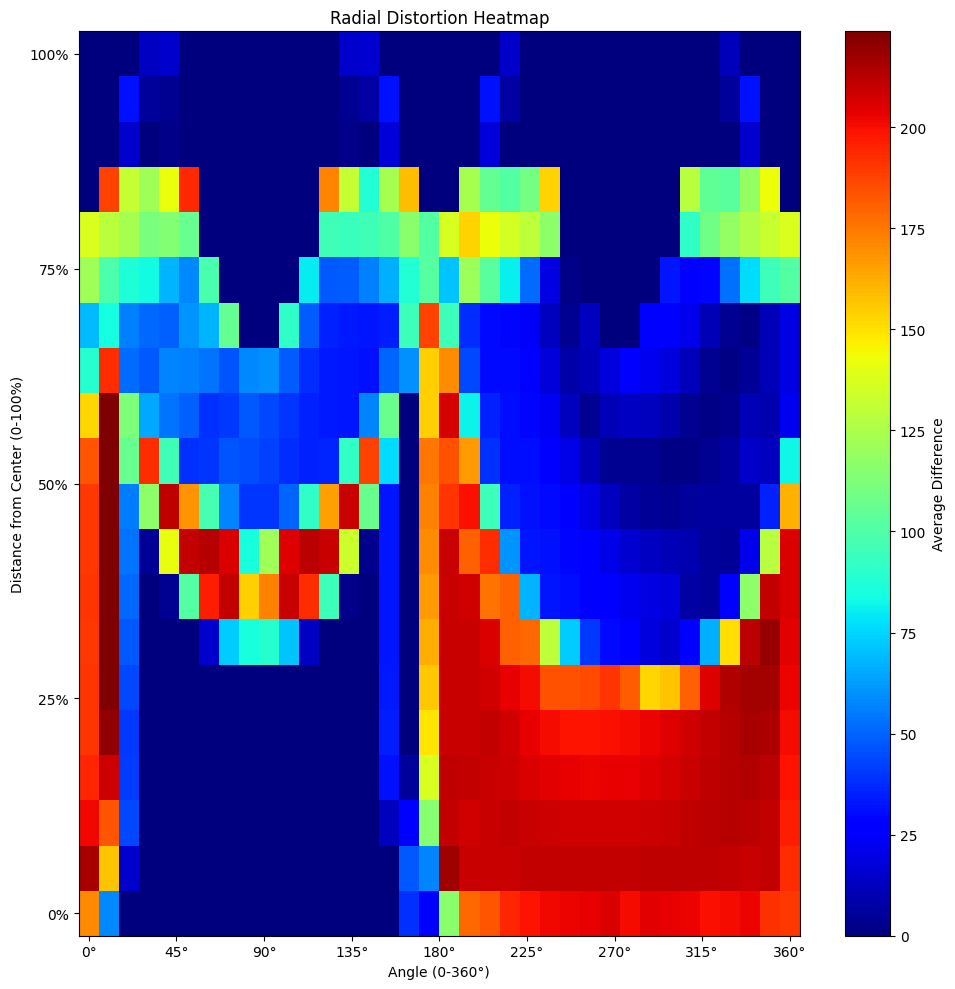


=== Distortion Analysis Summary ===
SSIM Score: 0.4820 (1.0 = identical, 0.0 = completely different)
PSNR: 29.01 dB
Gradient Entropy Difference: 0.2608
Relative Entropy Change: -9.85%

Radial Distortion Analysis:
Maximum Radial Difference: 200.00% at radius range (0.0, 0.1)

Visualizations saved in the 'distortion_analysis_output' folder
Detailed results saved to: distortion_analysis_output/distortion_analysis_results.json

To download results, use the following code:
from google.colab import files
files.download('distortion_analysis_output/distortion_analysis_results.json')
files.download('distortion_analysis_output/distortion_comparison_visualization.png')
files.download('distortion_analysis_output/radial_difference.png')
files.download('distortion_analysis_output/radial_heatmap.png')

To download all results at once:
!zip -r /content/distortion_results.zip distortion_analysis_output
from google.colab import files
files.download('/content/distortion_results.zip')
Ready to run analys

In [3]:
# Surround View Camera Distortion Comparison for Google Colab
# Run this cell to install required dependencies
!pip install opencv-python matplotlib scikit-image scipy

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from scipy.stats import entropy
from google.colab import files
import os
import json
from google.colab.patches import cv2_imshow  # Colab-specific image display

# Setup output directory
OUTPUT_DIR = "distortion_analysis_output"
!mkdir -p {OUTPUT_DIR}

def upload_images():
    """Upload images through Colab interface."""
    print("Please upload two images from surround view cameras mounted at different locations:")
    uploaded = files.upload()
    file_paths = list(uploaded.keys())

    if len(file_paths) != 2:
        print(f"You uploaded {len(file_paths)} files. Please upload exactly 2 images.")
        return None, None

    print(f"Successfully uploaded: {file_paths[0]} and {file_paths[1]}")
    return file_paths[0], file_paths[1]

def load_images(img1_path, img2_path):
    """Load two images and convert to grayscale."""
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)

    if img1 is None or img2 is None:
        raise ValueError("Could not open or find the images")

    # Convert to grayscale for certain analyses
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    return img1, img2, gray1, gray2

def resize_images(img1, img2):
    """Resize images to match dimensions."""
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    if h1 != h2 or w1 != w2:
        print(f"Resizing images: Image 1 ({w1}x{h1}), Image 2 ({w2}x{h2})")
        # Resize the second image to match the first
        img2 = cv2.resize(img2, (w1, h1))

    return img1, img2

def detect_chessboard(gray_img, chessboard_size=(9, 6)):
    """Detect chessboard corners for calibration pattern if present."""
    ret, corners = cv2.findChessboardCorners(gray_img, chessboard_size, None)
    if ret:
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        corners = cv2.cornerSubPix(gray_img, corners, (11, 11), (-1, -1), criteria)
    return ret, corners

def calculate_reprojection_error(img, corners, chessboard_size=(9, 6)):
    """Calculate reprojection error if chessboard is detected."""
    if corners is None:
        return None

    # Prepare object points (0,0,0), (1,0,0), (2,0,0) ...
    objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)

    # Find intrinsic and extrinsic parameters
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
        [objp], [corners], img.shape[::-1], None, None
    )

    # Calculate reprojection error
    mean_error = 0
    for i in range(len(objp)):
        imgpoints2, _ = cv2.projectPoints(objp, rvecs[0], tvecs[0], mtx, dist)
        error = cv2.norm(corners, imgpoints2, cv2.NORM_L2) / len(imgpoints2)
        mean_error += error

    return mean_error / len(objp)

def estimate_distortion(gray_img):
    """Estimate distortion using gradient analysis."""
    # Apply Sobel operators to detect edges
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=5)

    # Calculate gradient magnitude and direction
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    direction = np.arctan2(sobely, sobelx) * (180 / np.pi) % 180

    # Analyze distribution of gradient directions
    hist, _ = np.histogram(direction, bins=36, range=(0, 180))
    normalized_hist = hist / np.sum(hist)

    # Calculate entropy of gradient direction distribution
    # Higher entropy suggests more varied gradients, potentially indicating distortion
    gradient_entropy = entropy(normalized_hist)

    # Calculate standard deviation of gradient magnitude
    # Higher std can indicate more varied edge strengths due to distortion
    magnitude_std = np.std(magnitude)

    return {
        'gradient_entropy': gradient_entropy,
        'magnitude_std': magnitude_std,
        'max_magnitude': np.max(magnitude),
        'median_magnitude': np.median(magnitude)
    }

def calculate_radial_distortion_metrics(gray_img):
    """Calculate metrics that might indicate radial distortion."""
    height, width = gray_img.shape
    center_y, center_x = height // 2, width // 2

    # Create distance map from center
    y, x = np.indices((height, width))
    distance_from_center = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    max_distance = np.max(distance_from_center)
    normalized_distance = distance_from_center / max_distance

    # Create bins for radial analysis
    num_bins = 10
    radial_metrics = []

    for i in range(num_bins):
        lower = i / num_bins
        upper = (i + 1) / num_bins

        # Create mask for this radial segment
        mask = (normalized_distance >= lower) & (normalized_distance < upper)

        if np.sum(mask) > 0:
            # Calculate metrics for this radial segment
            segment_pixels = gray_img[mask]
            segment_metrics = {
                'bin_range': (lower, upper),
                'mean_intensity': float(np.mean(segment_pixels)),  # Convert to float for JSON serialization
                'std_intensity': float(np.std(segment_pixels)),
                'pixel_count': int(np.sum(mask))
            }

            # Calculate gradient metrics in this segment
            if np.sum(mask) > 100:  # Ensure enough pixels for gradient calculation
                sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=3)
                sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=3)
                segment_gradient_x = sobelx[mask]
                segment_gradient_y = sobely[mask]
                segment_metrics['gradient_magnitude_mean'] = float(np.mean(np.sqrt(segment_gradient_x**2 + segment_gradient_y**2)))

            radial_metrics.append(segment_metrics)

    return radial_metrics

def calculate_similarity_metrics(gray1, gray2):
    """Calculate similarity metrics between two images."""
    if gray1.shape != gray2.shape:
        gray2 = cv2.resize(gray2, (gray1.shape[1], gray1.shape[0]))

    # Calculate SSIM
    ssim_score, _ = ssim(gray1, gray2, full=True)

    # Calculate MSE
    mse = np.mean((gray1 - gray2) ** 2)

    # Calculate PSNR
    if mse == 0:
        psnr = float('inf')
    else:
        psnr = 10 * np.log10(255**2 / mse)

    return {
        'ssim': float(ssim_score),
        'mse': float(mse),
        'psnr': float(psnr)
    }

def visualize_distortion(img1, img2, gray1, gray2, output_path):
    """Create visualizations to highlight distortion differences."""
    # Resize if needed
    if img1.shape != img2.shape:
        img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))
        gray2 = cv2.resize(gray2, (gray1.shape[1], gray1.shape[0]))

    # Create gradient magnitude images
    sobelx1 = cv2.Sobel(gray1, cv2.CV_64F, 1, 0, ksize=5)
    sobely1 = cv2.Sobel(gray1, cv2.CV_64F, 0, 1, ksize=5)
    mag1 = np.sqrt(sobelx1**2 + sobely1**2)
    mag1 = cv2.normalize(mag1, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    sobelx2 = cv2.Sobel(gray2, cv2.CV_64F, 1, 0, ksize=5)
    sobely2 = cv2.Sobel(gray2, cv2.CV_64F, 0, 1, ksize=5)
    mag2 = np.sqrt(sobelx2**2 + sobely2**2)
    mag2 = cv2.normalize(mag2, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Calculate absolute difference
    diff = cv2.absdiff(gray1, gray2)
    diff = cv2.normalize(diff, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Apply color map for better visualization
    diff_color = cv2.applyColorMap(diff, cv2.COLORMAP_JET)

    # Create visualization
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))

    axs[0, 0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    axs[0, 0].set_title('Camera 1')
    axs[0, 0].axis('off')

    axs[0, 1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    axs[0, 1].set_title('Camera 2')
    axs[0, 1].axis('off')

    axs[0, 2].imshow(cv2.cvtColor(diff_color, cv2.COLOR_BGR2RGB))
    axs[0, 2].set_title('Difference Map')
    axs[0, 2].axis('off')

    axs[1, 0].imshow(mag1, cmap='gray')
    axs[1, 0].set_title('Gradient Magnitude (Camera 1)')
    axs[1, 0].axis('off')

    axs[1, 1].imshow(mag2, cmap='gray')
    axs[1, 1].set_title('Gradient Magnitude (Camera 2)')
    axs[1, 1].axis('off')

    # Plot histogram of pixel differences
    axs[1, 2].hist(diff.ravel(), bins=50, range=(0, 255))
    axs[1, 2].set_title('Histogram of Differences')
    axs[1, 2].set_xlabel('Difference Value')
    axs[1, 2].set_ylabel('Frequency')

    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()

    # Create additional visualizations for radial distortion
    # Radial difference visualization
    height, width = gray1.shape
    center_y, center_x = height // 2, width // 2

    # Create distance map from center
    y, x = np.indices((height, width))
    distance_from_center = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    max_distance = np.max(distance_from_center)
    normalized_distance = distance_from_center / max_distance

    # Create radial visualization
    plt.figure(figsize=(12, 5))

    # Create 10 radial bins
    num_bins = 10
    radial_diff_means = []
    radial_labels = []

    for i in range(num_bins):
        lower = i / num_bins
        upper = (i + 1) / num_bins

        # Create mask for this radial segment
        mask = (normalized_distance >= lower) & (normalized_distance < upper)

        if np.sum(mask) > 0:
            # Calculate diff for this segment
            segment_diff = diff[mask]
            radial_diff_means.append(np.mean(segment_diff))
            radial_labels.append(f"{int(lower*100)}-{int(upper*100)}%")

    plt.bar(radial_labels, radial_diff_means)
    plt.title('Average Difference by Radial Distance from Center')
    plt.xlabel('Distance from Center (% of max radius)')
    plt.ylabel('Average Difference')
    plt.xticks(rotation=45)
    plt.tight_layout()
    radial_viz_path = os.path.join(os.path.dirname(output_path), 'radial_difference.png')
    plt.savefig(radial_viz_path)
    plt.show()

    return output_path, radial_viz_path

def create_radial_heatmap(gray1, gray2, output_path):
    """Create a radial heatmap showing where differences are most pronounced."""
    # Ensure same size
    if gray1.shape != gray2.shape:
        gray2 = cv2.resize(gray2, (gray1.shape[1], gray1.shape[0]))

    # Calculate difference
    diff = cv2.absdiff(gray1, gray2)

    # Create radial coordinates
    height, width = gray1.shape
    center_y, center_x = height // 2, width // 2
    y, x = np.indices((height, width))

    # Calculate polar coordinates
    r = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    theta = np.arctan2(y - center_y, x - center_x)

    # Normalize radius to 0-1
    max_r = np.max(r)
    r_norm = r / max_r

    # Create a polar heatmap
    r_bins = 20
    theta_bins = 36

    # Convert theta from [-pi, pi] to [0, 2pi]
    theta_norm = (theta + 2*np.pi) % (2*np.pi)

    polar_heatmap = np.zeros((r_bins, theta_bins))
    counts = np.zeros((r_bins, theta_bins))

    # Assign differences to bins
    for i in range(height):
        for j in range(width):
            r_bin = min(int(r_norm[i, j] * r_bins), r_bins-1)
            theta_bin = min(int(theta_norm[i, j] / (2*np.pi) * theta_bins), theta_bins-1)
            polar_heatmap[r_bin, theta_bin] += diff[i, j]
            counts[r_bin, theta_bin] += 1

    # Average the differences
    mask = counts > 0
    polar_heatmap[mask] /= counts[mask]

    # Visualize the polar heatmap
    plt.figure(figsize=(10, 10))
    plt.imshow(polar_heatmap, cmap='jet', aspect='auto', origin='lower')
    plt.colorbar(label='Average Difference')
    plt.title('Radial Distortion Heatmap')
    plt.xlabel('Angle (0-360°)')
    plt.ylabel('Distance from Center (0-100%)')

    # Add custom y-ticks as percentage from center
    plt.yticks(np.linspace(0, r_bins-1, 5), ['0%', '25%', '50%', '75%', '100%'])

    # Add custom x-ticks as degrees
    plt.xticks(np.linspace(0, theta_bins-1, 9),
              ['0°', '45°', '90°', '135°', '180°', '225°', '270°', '315°', '360°'])

    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()

    return output_path

def compare_distortion(img1_path, img2_path, output_prefix="distortion_analysis"):
    """Main function to compare distortion between two camera images."""
    # Create output directory in Colab
    output_dir = OUTPUT_DIR
    output_prefix = os.path.join(output_dir, output_prefix)

    # Load images
    img1, img2, gray1, gray2 = load_images(img1_path, img2_path)
    print(f"Loaded images: {img1_path} and {img2_path}")

    # Resize to match dimensions if needed
    img1, img2 = resize_images(img1, img2)
    gray1, gray2 = resize_images(gray1, gray2)

    results = {
        'image1_path': img1_path,
        'image2_path': img2_path,
        'image1_shape': [int(v) for v in img1.shape],
        'image2_shape': [int(v) for v in img2.shape]
    }

    # Check for calibration pattern
    print("Checking for calibration pattern...")
    has_chessboard1, corners1 = detect_chessboard(gray1)
    has_chessboard2, corners2 = detect_chessboard(gray2)

    if has_chessboard1 and has_chessboard2:
        print("Calibration pattern found in both images, calculating reprojection error...")
        error1 = calculate_reprojection_error(gray1, corners1)
        error2 = calculate_reprojection_error(gray2, corners2)
        results['calibration'] = {
            'image1_reprojection_error': float(error1),
            'image2_reprojection_error': float(error2),
            'error_difference': float(abs(error1 - error2)) if error1 and error2 else None
        }
    else:
        print("No calibration pattern detected in at least one image, skipping reprojection error...")

    # Estimate distortion using gradient analysis
    print("Estimating distortion using gradient analysis...")
    dist1 = estimate_distortion(gray1)
    dist2 = estimate_distortion(gray2)

    results['gradient_analysis'] = {
        'image1': dist1,
        'image2': dist2,
        'entropy_difference': float(abs(dist1['gradient_entropy'] - dist2['gradient_entropy'])),
        'magnitude_std_difference': float(abs(dist1['magnitude_std'] - dist2['magnitude_std'])),
        'relative_entropy_change': float((dist1['gradient_entropy'] - dist2['gradient_entropy']) / ((dist1['gradient_entropy'] + dist2['gradient_entropy']) / 2) * 100)
    }

    # Calculate radial distortion metrics
    print("Calculating radial distortion metrics...")
    radial1 = calculate_radial_distortion_metrics(gray1)
    radial2 = calculate_radial_distortion_metrics(gray2)

    # Compare radial metrics
    radial_comparison = []
    for bin1, bin2 in zip(radial1, radial2):
        if bin1['bin_range'] == bin2['bin_range']:
            comparison = {
                'bin_range': bin1['bin_range'],
                'mean_intensity_diff': float(abs(bin1['mean_intensity'] - bin2['mean_intensity'])),
                'std_intensity_diff': float(abs(bin1['std_intensity'] - bin2['std_intensity'])),
                'relative_mean_diff': float(abs(bin1['mean_intensity'] - bin2['mean_intensity']) / ((bin1['mean_intensity'] + bin2['mean_intensity']) / 2) * 100 if bin1['mean_intensity'] + bin2['mean_intensity'] > 0 else 0)
            }
            if 'gradient_magnitude_mean' in bin1 and 'gradient_magnitude_mean' in bin2:
                comparison['gradient_magnitude_diff'] = float(abs(bin1['gradient_magnitude_mean'] - bin2['gradient_magnitude_mean']))
            radial_comparison.append(comparison)

    results['radial_analysis'] = radial_comparison

    # Calculate similarity metrics
    print("Calculating similarity metrics...")
    similarity = calculate_similarity_metrics(gray1, gray2)
    results['similarity'] = similarity

    # Create visualizations
    print("Creating visualizations...")
    viz_path = os.path.join(output_dir, 'distortion_comparison_visualization.png')
    viz_path, radial_viz_path = visualize_distortion(img1, img2, gray1, gray2, viz_path)

    # Create radial heatmap
    heatmap_path = os.path.join(output_dir, 'radial_heatmap.png')
    heatmap_path = create_radial_heatmap(gray1, gray2, heatmap_path)

    results['visualization_paths'] = {
        'comparison': viz_path,
        'radial_diff': radial_viz_path,
        'radial_heatmap': heatmap_path
    }

    # Export results to JSON
    results_path = f"{output_prefix}_results.json"
    with open(results_path, 'w') as f:
        json.dump(results, f, indent=4)

    # Print summary
    print("\n=== Distortion Analysis Summary ===")
    print(f"SSIM Score: {similarity['ssim']:.4f} (1.0 = identical, 0.0 = completely different)")
    print(f"PSNR: {similarity['psnr']:.2f} dB")
    print(f"Gradient Entropy Difference: {results['gradient_analysis']['entropy_difference']:.4f}")
    print(f"Relative Entropy Change: {results['gradient_analysis']['relative_entropy_change']:.2f}%")

    if 'calibration' in results:
        print("\nCalibration Analysis:")
        print(f"Camera 1 Reprojection Error: {results['calibration']['image1_reprojection_error']:.4f}")
        print(f"Camera 2 Reprojection Error: {results['calibration']['image2_reprojection_error']:.4f}")
        print(f"Error Difference: {results['calibration']['error_difference']:.4f}")

    print("\nRadial Distortion Analysis:")
    max_bin_diff = 0
    max_bin_range = None
    for bin_comp in radial_comparison:
        if bin_comp['relative_mean_diff'] > max_bin_diff:
            max_bin_diff = bin_comp['relative_mean_diff']
            max_bin_range = bin_comp['bin_range']

    print(f"Maximum Radial Difference: {max_bin_diff:.2f}% at radius range {max_bin_range}")
    print(f"\nVisualizations saved in the '{output_dir}' folder")
    print(f"Detailed results saved to: {results_path}")

    # Download results
    print("\nTo download results, use the following code:")
    print("from google.colab import files")
    print(f"files.download('{results_path}')")
    print(f"files.download('{viz_path}')")
    print(f"files.download('{radial_viz_path}')")
    print(f"files.download('{heatmap_path}')")

    return results

# Main execution block for Colab
def main():
    """Run the distortion comparison analysis in Colab."""
    print("=== Surround View Camera Distortion Comparison ===")
    print("This notebook analyzes and compares distortion patterns between two")
    print("surround view camera images taken from different mounting locations.")

    # Let user upload images
    img1_path, img2_path = upload_images()

    if img1_path and img2_path:
        # Run the analysis
        results = compare_distortion(img1_path, img2_path)

        # Provide download links for results
        print("\nTo download all results at once:")
        print("!zip -r /content/distortion_results.zip " + OUTPUT_DIR)
        print("from google.colab import files")
        print("files.download('/content/distortion_results.zip')")

# Run the main function - uncomment this line to run the analysis
main()

# To run the analysis, simply execute this cell and then uncomment and run the line above
print("Ready to run analysis. Uncomment the 'main()' line at the bottom of this cell and run again to start.")
print("Or call main() in a new cell.")

In [5]:
# Surround View Camera Distortion Comparison for YOLO Training - Google Colab
# Run this cell to install required dependencies
!pip install opencv-python matplotlib scikit-image scipy

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from scipy.stats import entropy
from google.colab import files
import os
import json
from google.colab.patches import cv2_imshow  # Colab-specific image display

# Setup output directory
OUTPUT_DIR = "distortion_analysis_output"
!mkdir -p {OUTPUT_DIR}

def upload_images():
    """Upload images through Colab interface."""
    print("Please upload two images from surround view cameras mounted at different locations:")
    uploaded = files.upload()
    file_paths = list(uploaded.keys())

    if len(file_paths) != 2:
        print(f"You uploaded {len(file_paths)} files. Please upload exactly 2 images.")
        return None, None

    print(f"Successfully uploaded: {file_paths[0]} and {file_paths[1]}")
    return file_paths[0], file_paths[1]

def load_images(img1_path, img2_path):
    """Load two images and convert to grayscale."""
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)

    if img1 is None or img2 is None:
        raise ValueError("Could not open or find the images")

    # Convert to grayscale for certain analyses
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    return img1, img2, gray1, gray2

def resize_images(img1, img2):
    """Resize images to match dimensions."""
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    if h1 != h2 or w1 != w2:
        print(f"Resizing images: Image 1 ({w1}x{h1}), Image 2 ({w2}x{h2})")
        # Resize the second image to match the first
        img2 = cv2.resize(img2, (w1, h1))

    return img1, img2

def calculate_yolo_relevant_metrics(img1, img2, gray1, gray2):
    """Calculate metrics specifically relevant for YOLO training."""
    # 1. Contrast and brightness differences (affect feature detection)
    contrast1 = np.std(gray1)
    contrast2 = np.std(gray2)
    brightness1 = np.mean(gray1)
    brightness2 = np.mean(gray2)

    # 2. Edge preservation (critical for object boundary detection)
    edges1 = cv2.Canny(gray1, 100, 200)
    edges2 = cv2.Canny(gray2, 100, 200)
    edge_preservation = np.sum(np.logical_and(edges1, edges2)) / max(np.sum(np.logical_or(edges1, edges2)), 1)

    # 3. Gradient magnitude differences (affect feature extraction)
    sobelx1 = cv2.Sobel(gray1, cv2.CV_64F, 1, 0, ksize=3)
    sobely1 = cv2.Sobel(gray1, cv2.CV_64F, 0, 1, ksize=3)
    sobelx2 = cv2.Sobel(gray2, cv2.CV_64F, 1, 0, ksize=3)
    sobely2 = cv2.Sobel(gray2, cv2.CV_64F, 0, 1, ksize=3)

    mag1 = np.sqrt(sobelx1**2 + sobely1**2)
    mag2 = np.sqrt(sobelx2**2 + sobely2**2)

    gradient_mag_diff = np.mean(np.abs(mag1 - mag2))

    # 4. Structural similarity (affects overall feature consistency)
    ssim_score, ssim_map = ssim(gray1, gray2, full=True)

    # 5. Color consistency (affects color-based features)
    hsv1 = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)
    hsv2 = cv2.cvtColor(img2, cv2.COLOR_BGR2HSV)

    hue_diff = np.mean(np.abs(hsv1[:,:,0].astype(float) - hsv2[:,:,0].astype(float)))
    sat_diff = np.mean(np.abs(hsv1[:,:,1].astype(float) - hsv2[:,:,1].astype(float)))

    # 6. Texture differences (critical for classification)
    glcm1 = get_texture_features(gray1)
    glcm2 = get_texture_features(gray2)
    texture_diff = np.mean([abs(a-b) for a, b in zip(glcm1, glcm2)])

    # 7. Local keypoint matches (important for feature matching)
    kp_consistency = calculate_keypoint_consistency(gray1, gray2)

    # 8. Angle consistency of gradients (direction agreement - important for feature extraction)
    angle1 = np.arctan2(sobely1, sobelx1) * (180 / np.pi) % 180
    angle2 = np.arctan2(sobely2, sobelx2) * (180 / np.pi) % 180
    # Calculate circular difference between angles
    angle_diff = np.minimum(np.abs(angle1 - angle2), 180 - np.abs(angle1 - angle2))
    angle_consistency = np.mean(angle_diff)

    return {
        "contrast_diff": float(abs(contrast1 - contrast2)),
        "contrast_ratio": float(min(contrast1, contrast2) / max(contrast1, contrast2)),
        "brightness_diff": float(abs(brightness1 - brightness2)),
        "edge_preservation": float(edge_preservation),
        "gradient_magnitude_diff": float(gradient_mag_diff),
        "gradient_direction_consistency": float(180 - angle_consistency) / 180,  # Normalized to 0-1
        "ssim": float(ssim_score),
        "hue_difference": float(hue_diff),
        "saturation_difference": float(sat_diff),
        "texture_difference": float(texture_diff),
        "keypoint_consistency": float(kp_consistency),
        "ssim_map": ssim_map
    }

def get_texture_features(gray_img, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    """Extract simple texture features from the image."""
    from skimage.feature import graycomatrix, graycoprops

    # Rescale to 0-255 if needed and convert to uint8
    if gray_img.dtype != np.uint8:
        gray_img = cv2.normalize(gray_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Compute GLCM matrix (downscale to speed up)
    scale_factor = 0.5
    small_img = cv2.resize(gray_img, None, fx=scale_factor, fy=scale_factor)
    glcm = graycomatrix(small_img, distances=distances, angles=angles,
                        levels=32, symmetric=True, normed=True)

    # Extract properties
    contrast = graycoprops(glcm, 'contrast').mean()
    dissimilarity = graycoprops(glcm, 'dissimilarity').mean()
    homogeneity = graycoprops(glcm, 'homogeneity').mean()
    energy = graycoprops(glcm, 'energy').mean()
    correlation = graycoprops(glcm, 'correlation').mean()

    return [contrast, dissimilarity, homogeneity, energy, correlation]

def calculate_keypoint_consistency(gray1, gray2):
    """Calculate the consistency of keypoints between images (similarity of feature points)."""
    # Detect keypoints and compute descriptors
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)

    # If no keypoints found, return 0
    if len(kp1) == 0 or len(kp2) == 0 or des1 is None or des2 is None:
        return 0.0

    # Match descriptors
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test to find good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # Calculate match ratio
    match_ratio = len(good_matches) / min(len(kp1), len(kp2))
    return match_ratio

def analyze_regions_of_interest(img1, img2, gray1, gray2):
    """Analyze differences in regions important for YOLO detection."""
    h, w = gray1.shape

    # Define region grid (3x3)
    regions = []
    for i in range(3):
        for j in range(3):
            x1 = j * (w // 3)
            y1 = i * (h // 3)
            x2 = (j + 1) * (w // 3)
            y2 = (i + 1) * (h // 3)

            region_name = f"{['Top', 'Middle', 'Bottom'][i]}-{['Left', 'Center', 'Right'][j]}"
            region = {
                "name": region_name,
                "coords": (x1, y1, x2, y2)
            }
            regions.append(region)

    # Center region is especially important for YOLO
    center_region = {
        "name": "Center",
        "coords": (w//4, h//4, 3*w//4, 3*h//4)
    }
    regions.append(center_region)

    # Analyze each region
    region_results = []
    for region in regions:
        x1, y1, x2, y2 = region["coords"]
        roi1 = gray1[y1:y2, x1:x2]
        roi2 = gray2[y1:y2, x1:x2]

        # Calculate SSIM for this region
        region_ssim, _ = ssim(roi1, roi2, full=True)

        # Calculate edge preservation
        roi_edges1 = cv2.Canny(roi1, 100, 200)
        roi_edges2 = cv2.Canny(roi2, 100, 200)
        edge_preservation = np.sum(np.logical_and(roi_edges1, roi_edges2)) / max(np.sum(np.logical_or(roi_edges1, roi_edges2)), 1)

        region_results.append({
            "region": region["name"],
            "ssim": float(region_ssim),
            "edge_preservation": float(edge_preservation),
            "mean_diff": float(np.mean(np.abs(roi1.astype(float) - roi2.astype(float))))
        })

    return region_results

def create_yolo_distortion_plots(metrics, region_results, output_dir):
    """Create separate plots for each metric relevant to YOLO training."""
    # 1. Plot contrast and brightness differences
    plt.figure(figsize=(12, 8))
    contrast_brightness = [
        metrics["contrast_ratio"],
        1 - (metrics["brightness_diff"] / 255)
    ]

    plt.bar(['Contrast Consistency', 'Brightness Consistency'], contrast_brightness, color=['skyblue', 'lightgreen'])
    plt.title('Contrast and Brightness Consistency (higher is better)')
    plt.ylim(0, 1.0)
    plt.grid(axis='y', alpha=0.3)
    contrast_path = os.path.join(output_dir, 'contrast_brightness.png')
    plt.savefig(contrast_path)
    plt.close()

    # 2. Plot feature preservation metrics
    plt.figure(figsize=(12, 8))
    feature_metrics = [
        metrics["edge_preservation"],
        metrics["gradient_direction_consistency"],
        metrics["keypoint_consistency"],
        metrics["ssim"]
    ]
    feature_names = [
        'Edge Preservation',
        'Gradient Direction',
        'Keypoint Consistency',
        'Structural Similarity'
    ]

    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
    plt.bar(feature_names, feature_metrics, color=colors)
    plt.title('Feature Preservation Metrics (higher is better)')
    plt.ylim(0, 1.0)
    plt.grid(axis='y', alpha=0.3)
    features_path = os.path.join(output_dir, 'feature_preservation.png')
    plt.savefig(features_path)
    plt.close()

    # 3. Plot color and texture consistency
    plt.figure(figsize=(12, 8))
    color_texture = [
        1 - min(1.0, metrics["hue_difference"] / 90),  # Normalize hue differences
        1 - min(1.0, metrics["saturation_difference"] / 127),  # Normalize saturation differences
        1 - min(1.0, metrics["texture_difference"])  # Texture differences already normalized
    ]

    plt.bar(['Hue Consistency', 'Saturation Consistency', 'Texture Consistency'],
            color_texture, color=['#ff99cc', '#99ccff', '#ccff99'])
    plt.title('Color and Texture Consistency (higher is better)')
    plt.ylim(0, 1.0)
    plt.grid(axis='y', alpha=0.3)
    color_path = os.path.join(output_dir, 'color_texture.png')
    plt.savefig(color_path)
    plt.close()

    # 4. Plot region-based SSIM values
    plt.figure(figsize=(14, 8))
    regions = [r["region"] for r in region_results]
    region_ssims = [r["ssim"] for r in region_results]
    region_colors = ['#c2c2f0' if 'Center' in r else '#ffb366' for r in regions]

    bars = plt.bar(regions, region_ssims, color=region_colors)
    plt.title('SSIM by Image Region')
    plt.xlabel('Image Region')
    plt.ylabel('SSIM Score (higher is better)')
    plt.ylim(0, 1.0)
    plt.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Highlight center region
    for i, r in enumerate(regions):
        if r == 'Center':
            bars[i].set_color('#ff6666')  # Highlight the center region
            plt.annotate('Critical for YOLO', (i, region_ssims[i]),
                        textcoords="offset points", xytext=(0,10), ha='center')

    regions_path = os.path.join(output_dir, 'region_ssim.png')
    plt.savefig(regions_path)
    plt.close()

    # 5. Plot region-based edge preservation
    plt.figure(figsize=(14, 8))
    region_edges = [r["edge_preservation"] for r in region_results]
    region_colors = ['#c2c2f0' if 'Center' in r else '#ffb366' for r in regions]

    bars = plt.bar(regions, region_edges, color=region_colors)
    plt.title('Edge Preservation by Image Region')
    plt.xlabel('Image Region')
    plt.ylabel('Edge Preservation Score (higher is better)')
    plt.ylim(0, 1.0)
    plt.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Highlight center region
    for i, r in enumerate(regions):
        if r == 'Center':
            bars[i].set_color('#ff6666')

    region_edges_path = os.path.join(output_dir, 'region_edges.png')
    plt.savefig(region_edges_path)
    plt.close()

    # 6. Create SSIM heatmap
    plt.figure(figsize=(10, 8))
    plt.imshow(metrics["ssim_map"], cmap='jet', vmin=0, vmax=1)
    plt.colorbar(label='SSIM Value')
    plt.title('SSIM Map (Structural Similarity)')
    plt.axis('off')
    ssim_map_path = os.path.join(output_dir, 'ssim_heatmap.png')
    plt.savefig(ssim_map_path)
    plt.close()

    # Return paths of all generated plots
    return {
        'contrast_brightness': contrast_path,
        'feature_preservation': features_path,
        'color_texture': color_path,
        'region_ssim': regions_path,
        'region_edges': region_edges_path,
        'ssim_map': ssim_map_path
    }

def yolo_impact_assessment(metrics, region_results):
    """Assess the potential impact of camera differences on YOLO performance."""
    # Weight factors (based on empirical importance for YOLO)
    weights = {
        'center_region_ssim': 0.25,
        'edge_preservation': 0.20,
        'keypoint_consistency': 0.15,
        'contrast_ratio': 0.10,
        'gradient_direction': 0.10,
        'color_consistency': 0.10,
        'texture_consistency': 0.10
    }

    # Get center region SSIM
    center_ssim = 0
    for region in region_results:
        if region['region'] == 'Center':
            center_ssim = region['ssim']
            break

    # Calculate color consistency average
    color_consistency = (
        (1 - min(1.0, metrics["hue_difference"] / 90)) +
        (1 - min(1.0, metrics["saturation_difference"] / 127))
    ) / 2

    # Calculate weighted score
    score_components = {
        'center_region_ssim': center_ssim * weights['center_region_ssim'],
        'edge_preservation': metrics['edge_preservation'] * weights['edge_preservation'],
        'keypoint_consistency': metrics['keypoint_consistency'] * weights['keypoint_consistency'],
        'contrast_ratio': metrics['contrast_ratio'] * weights['contrast_ratio'],
        'gradient_direction': metrics['gradient_direction_consistency'] * weights['gradient_direction'],
        'color_consistency': color_consistency * weights['color_consistency'],
        'texture_consistency': (1 - min(1.0, metrics['texture_difference'])) * weights['texture_consistency']
    }

    # Total score (0-100)
    total_score = sum(score_components.values()) * 100

    # Assessment based on score
    if total_score >= 85:
        impact = "Low impact - Camera differences are minimal and unlikely to significantly affect YOLO training performance."
    elif total_score >= 70:
        impact = "Moderate impact - Some differences exist that may affect detection consistency. Consider data augmentation to handle these variations."
    elif total_score >= 50:
        impact = "High impact - Significant differences exist that will likely affect YOLO performance. Strong data augmentation and location-specific tuning recommended."
    else:
        impact = "Critical impact - Major differences that will severely impact YOLO training. Consider camera recalibration or separate models for each camera location."

    # Specific recommendations
    recommendations = []

    if metrics['contrast_ratio'] < 0.8:
        recommendations.append("Apply contrast normalization during preprocessing")

    if metrics['brightness_diff'] > 20:
        recommendations.append("Include brightness augmentation in training")

    if metrics['edge_preservation'] < 0.7:
        recommendations.append("Focus on edge enhancement preprocessing")

    if metrics['keypoint_consistency'] < 0.6:
        recommendations.append("Use heavier augmentation for geometric transformations")

    if color_consistency < 0.7:
        recommendations.append("Add color jittering to the augmentation pipeline")

    if center_ssim < 0.8:
        recommendations.append("Critical: Center region shows significant differences. Consider location-specific calibration.")

    # Return assessment
    return {
        'score': float(total_score),
        'score_components': {k: float(v) for k, v in score_components.items()},
        'impact_assessment': impact,
        'recommendations': recommendations
    }

def compare_distortion_for_yolo(img1_path, img2_path, output_prefix="yolo_distortion_analysis"):
    """Compare distortion between two camera images with focus on YOLO-relevant metrics."""
    # Create output directory in Colab
    output_dir = OUTPUT_DIR
    output_prefix = os.path.join(output_dir, output_prefix)

    # Load images
    img1, img2, gray1, gray2 = load_images(img1_path, img2_path)
    print(f"Loaded images: {img1_path} and {img2_path}")

    # Resize to match dimensions if needed
    img1, img2 = resize_images(img1, img2)
    gray1, gray2 = resize_images(gray1, gray2)

    # Calculate YOLO-relevant metrics
    print("Calculating YOLO-relevant metrics...")
    yolo_metrics = calculate_yolo_relevant_metrics(img1, img2, gray1, gray2)

    # Analyze regions of interest
    print("Analyzing regions of interest...")
    region_results = analyze_regions_of_interest(img1, img2, gray1, gray2)

    # Create metric plots
    print("Creating visualization plots...")
    plot_paths = create_yolo_distortion_plots(yolo_metrics, region_results, output_dir)

    # Assess impact on YOLO training
    print("Assessing impact on YOLO training...")
    impact_assessment = yolo_impact_assessment(yolo_metrics, region_results)

    # Combine all results
    results = {
        'image1_path': img1_path,
        'image2_path': img2_path,
        'image_shapes': {
            'image1': [int(v) for v in img1.shape],
            'image2': [int(v) for v in img2.shape]
        },
        'yolo_metrics': {k: v for k, v in yolo_metrics.items() if k != 'ssim_map'},
        'region_analysis': region_results,
        'plot_paths': plot_paths,
        'impact_assessment': impact_assessment
    }

    # Save to JSON
    results_path = f"{output_prefix}_results.json"
    with open(results_path, 'w') as f:
        json.dump(results, f, indent=4)

    # Create a summary visualization
    create_summary_visualization(yolo_metrics, region_results, impact_assessment, output_dir)

    # Print summary
    print("\n=== YOLO Distortion Analysis Summary ===")
    print(f"Overall Compatibility Score: {impact_assessment['score']:.1f}/100")
    print(f"Impact Assessment: {impact_assessment['impact_assessment']}")

    print("\nKey Metrics:")
    print(f"- Structural Similarity (SSIM): {yolo_metrics['ssim']:.4f}")
    print(f"- Edge Preservation: {yolo_metrics['edge_preservation']:.4f}")
    print(f"- Feature Point Consistency: {yolo_metrics['keypoint_consistency']:.4f}")
    print(f"- Contrast Ratio: {yolo_metrics['contrast_ratio']:.4f}")

    print("\nRecommendations:")
    for i, rec in enumerate(impact_assessment['recommendations'], 1):
        print(f"{i}. {rec}")

    print(f"\nDetailed results saved to: {results_path}")
    print(f"Visualizations saved in: {output_dir}")

    # Download instructions
    print("\nTo download results, use the following code:")
    print("from google.colab import files")
    print(f"files.download('{results_path}')")
    print("# Or download all results at once:")
    print("!zip -r /content/yolo_distortion_results.zip " + OUTPUT_DIR)
    print("files.download('/content/yolo_distortion_results.zip')")

    return results

def create_summary_visualization(metrics, region_results, impact, output_dir):
    """Create a summary visualization with all key metrics for YOLO training."""
    # Set up the figure with subplots
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 3)

    # 1. Overall score gauge chart (top left)
    ax1 = fig.add_subplot(gs[0, 0])
    create_gauge_chart(ax1, impact['score'], 'Overall Score', 0, 100)

    # 2. Metrics spider chart (top center)
    ax2 = fig.add_subplot(gs[0, 1], polar=True)
    create_spider_chart(ax2, metrics, impact)

    # 3. Region SSIM heatmap table (top right)
    ax3 = fig.add_subplot(gs[0, 2])
    create_region_heatmap_table(ax3, region_results)

    # 4. Impact breakdown (middle row)
    ax4 = fig.add_subplot(gs[1, :])
    create_impact_breakdown(ax4, impact)

    # 5. Structural similarity map (bottom left)
    ax5 = fig.add_subplot(gs[2, 0])
    ax5.imshow(metrics["ssim_map"], cmap='jet', vmin=0, vmax=1)
    ax5.set_title('SSIM Map')
    ax5.axis('off')

    # 6. Recommendations (bottom right two columns)
    ax6 = fig.add_subplot(gs[2, 1:])
    create_recommendations_panel(ax6, impact['recommendations'])

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    # Save the figure
    summary_path = os.path.join(output_dir, 'yolo_summary.png')
    plt.savefig(summary_path, bbox_inches='tight', dpi=150)
    plt.close()

    return summary_path

def create_gauge_chart(ax, value, title, min_val=0, max_val=100, colors=['#ff0000', '#ffcc00', '#00cc00']):
    """Create a gauge chart for the overall score."""
    import matplotlib.patches as patches

    # Gauge settings
    gauge_width = 0.1

    # Create the colored background
    theta = np.linspace(np.pi, 0, 100)
    r = np.ones_like(theta) - gauge_width

    # Color thresholds
    low_thresh = 50
    high_thresh = 75

    # Create the gauge color sections
    points = (max_val - min_val) / len(theta)
    colored_thetas = []
    colored_rs = []

    for i, angle in enumerate(theta):
        current_value = min_val + i * points

        if current_value < low_thresh:
            color = colors[0]  # Red
        elif current_value < high_thresh:
            color = colors[1]  # Yellow
        else:
            color = colors[2]  # Green

        colored_thetas.append(angle)
        colored_rs.append(r[i])

        if i > 0:
            # Create a small patch
            wedge = patches.Wedge(
                (0, 0),
                1.0,
                theta[i-1] * 180/np.pi,
                angle * 180/np.pi,
                width=gauge_width,
                color=color,
                alpha=0.7
            )
            ax.add_patch(wedge)

    # Add the needle
    normalized_value = (value - min_val) / (max_val - min_val)
    needle_angle = np.pi - normalized_value * np.pi

    ax.plot([0, 0.8 * np.cos(needle_angle)], [0, 0.8 * np.sin(needle_angle)], 'k-', lw=2)
    ax.add_patch(patches.Circle((0, 0), 0.05, color='black'))

    # Add the value text
    ax.text(0, -0.2, f"{value:.1f}", ha='center', va='center', fontsize=24, fontweight='bold')

    # Add min and max labels
    ax.text(-0.9, 0, str(min_val), ha='center', va='center', fontsize=10)
    ax.text(0.9, 0, str(max_val), ha='center', va='center', fontsize=10)

    # Add threshold markers
    low_angle = np.pi - (low_thresh - min_val) / (max_val - min_val) * np.pi
    high_angle = np.pi - (high_thresh - min_val) / (max_val - min_val) * np.pi

    ax.plot([0.7 * np.cos(low_angle), 0.9 * np.cos(low_angle)],
            [0.7 * np.sin(low_angle), 0.9 * np.sin(low_angle)], 'k-', lw=1)
    ax.plot([0.7 * np.cos(high_angle), 0.9 * np.cos(high_angle)],
            [0.7 * np.sin(high_angle), 0.9 * np.sin(high_angle)], 'k-', lw=1)

    # Set title
    ax.text(0, 0.6, title, ha='center', va='center', fontsize=14, fontweight='bold')

    # Set limits and turn off axis
    ax.set_xlim(-1, 1)
    ax.set_ylim(-0.5, 1)
    ax.axis('off')

def create_spider_chart(ax, metrics, impact):
    """Create a spider chart of key metrics relevant to YOLO training."""
    # Define categories and values
    categories = [
        'SSIM',
        'Edge Preservation',
        'Feature Points',
        'Contrast',
        'Gradient Direction',
        'Color'
    ]

    values = [
        metrics['ssim'],
        metrics['edge_preservation'],
        metrics['keypoint_consistency'],
        metrics['contrast_ratio'],
        metrics['gradient_direction_consistency'],
        (1 - min(1.0, metrics["hue_difference"] / 90) +
         1 - min(1.0, metrics["saturation_difference"] / 127)) / 2
    ]

    # Number of categories
    N = len(categories)

    # Compute angle for each category
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop

    # Add values (and close the loop)
    values += values[:1]

    # Set up the plot
    ax.set_theta_offset(np.pi / 2)  # Start from top
    ax.set_theta_direction(-1)  # Go clockwise

    # Draw the polygon
    ax.plot(angles, values, linewidth=2, linestyle='solid', color='#3366cc')
    ax.fill(angles, values, alpha=0.25, color='#3366cc')

    # Add threshold circles
    ax.set_ylim(0, 1)
    plt.yticks([0.25, 0.5, 0.75], ["0.25", "0.5", "0.75"], color="grey", size=8)

    # Add category labels
    plt.xticks(angles[:-1], categories, size=10)

    # Draw y-axis lines
    ax.set_rlabel_position(0)
    ax.grid(True)

    ax.set_title("Key Metrics", size=12, pad=10)

def create_region_heatmap_table(ax, region_results):
    """Create a heatmap-style table of SSIM scores by region."""
    # Extract regions and scores
    regions = []
    scores = []

    # Organize regions in a 3x3 grid + center
    grid = {}
    center_value = None

    for result in region_results:
        region_name = result['region']
        if region_name == 'Center':
            center_value = result['ssim']
        else:
            parts = region_name.split('-')
            if len(parts) == 2:
                grid[(parts[0], parts[1])] = result['ssim']

    # Set up grid for display
    display_grid = np.zeros((3, 3))
    for i, row in enumerate(['Top', 'Middle', 'Bottom']):
        for j, col in enumerate(['Left', 'Center', 'Right']):
            if (row, col) in grid:
                display_grid[i, j] = grid[(row, col)]

    # Draw the grid
    im = ax.imshow(display_grid, cmap='RdYlGn', vmin=0, vmax=1)

    # Add center region overlay
    if center_value is not None:
        center_rect = plt.Rectangle((0.5, 0.5), 2, 2, fill=False, edgecolor='black', linewidth=3, clip_on=False)
        ax.add_patch(center_rect)
        ax.text(1, 1, f'Center\n{center_value:.2f}', ha='center', va='center',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))

    # Add text annotations
    for i in range(3):
        for j in range(3):
            text = ax.text(j, i, f'{display_grid[i, j]:.2f}',
                      ha="center", va="center", color="black", fontsize=9)

    # Add row and column labels
    ax.set_xticks(np.arange(3))
    ax.set_yticks(np.arange(3))
    ax.set_xticklabels(['Left', 'Center', 'Right'])
    ax.set_yticklabels(['Top', 'Middle', 'Bottom'])

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('SSIM Score', rotation=270, labelpad=15)

    ax.set_title('Region Analysis', fontsize=12)

def create_impact_breakdown(ax, impact):
    """Create a bar chart showing the contribution of each component to the overall score."""
    components = list(impact['score_components'].keys())
    values = list(impact['score_components'].values())

    # Create readable labels
    readable_components = {
        'center_region_ssim': 'Center Region',
        'edge_preservation': 'Edge Detection',
        'keypoint_consistency': 'Feature Points',
        'contrast_ratio': 'Contrast',
        'gradient_direction': 'Gradient Direction',
        'color_consistency': 'Color Consistency',
        'texture_consistency': 'Texture Analysis'
    }

    labels = [readable_components.get(c, c) for c in components]
    normalized_values = [v * 100 for v in values]  # Scale to percentage

    # Sort by value
    sorted_indices = np.argsort(normalized_values)[::-1]
    sorted_labels = [labels[i] for i in sorted_indices]
    sorted_values = [normalized_values[i] for i in sorted_indices]

    # Define colors based on importance
    colors = plt.cm.YlGnBu(np.linspace(0.2, 0.8, len(sorted_values)))

    # Create bars
    bars = ax.barh(sorted_labels, sorted_values, color=colors)

    # Add percentage labels
    for i, v in enumerate(sorted_values):
        ax.text(v + 0.5, i, f"{v:.1f}%", va='center')

    # Add title and labels
    ax.set_title('Score Contribution by Component', fontsize=12)
    ax.set_xlabel('Contribution to Overall Score (%)')

    # Set limits
    ax.set_xlim(0, max(normalized_values) * 1.2)

    # Add grid
    ax.grid(axis='x', linestyle='--', alpha=0.7)

def create_recommendations_panel(ax, recommendations):
    """Create a text panel with recommendations for YOLO training."""
    if not recommendations:
        recommendations = ["No specific recommendations. Camera differences are minimal."]

    # Clear axis
    ax.axis('off')

    # Create title
    ax.text(0.5, 0.95, 'Recommendations for YOLO Training',
            ha='center', va='top', fontsize=14, fontweight='bold')

    # Add recommendations as bullet points
    for i, rec in enumerate(recommendations):
        ax.text(0.05, 0.85 - i*0.15, f"• {rec}", va='top', fontsize=11, wrap=True)

    # Add a border
    border = plt.Rectangle((0, 0), 1, 1, fill=False, edgecolor='gray', linewidth=1, transform=ax.transAxes)
    ax.add_patch(border)

# Main execution function
def main():
    """Run the distortion comparison analysis for YOLO in Colab."""
    print("=== Surround View Camera Distortion Comparison for YOLO Training ===")
    print("This notebook analyzes and compares distortion patterns between two")
    print("surround view camera images and assesses impact on YOLO model training.")

    # Let user upload images
    img1_path, img2_path = upload_images()

    if img1_path and img2_path:
        # Run the analysis
        results = compare_distortion_for_yolo(img1_path, img2_path)

        # Provide download links for results
        print("\nTo download all results at once:")
        print("!zip -r /content/yolo_distortion_results.zip " + OUTPUT_DIR)
        print("from google.colab import files")
        print("files.download('/content/yolo_distortion_results.zip')")

# Run the main function - uncomment this line to run the analysis
main()

# To run the analysis, simply execute this cell and then uncomment and run the line above
print("Ready to run analysis. Uncomment the 'main()' line at the bottom of this cell and run again to start.")
print("Or call main() in a new cell.")

=== Surround View Camera Distortion Comparison for YOLO Training ===
This notebook analyzes and compares distortion patterns between two
surround view camera images and assesses impact on YOLO model training.
Please upload two images from surround view cameras mounted at different locations:


Saving image (171).png to image (171) (2).png
Saving image (172).png to image (172) (1).png
Successfully uploaded: image (171) (2).png and image (172) (1).png
Loaded images: image (171) (2).png and image (172) (1).png
Resizing images: Image 1 (1920x1536), Image 2 (1047x824)
Resizing images: Image 1 (1920x1536), Image 2 (1047x824)
Calculating YOLO-relevant metrics...


ValueError: The maximum grayscale value in the image should be smaller than the number of levels.

In [7]:
# Surround View Camera Distortion Comparison for YOLO Training - Google Colab
# Run this cell to install required dependencies
!pip install opencv-python matplotlib scikit-image scipy

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from scipy.stats import entropy
from google.colab import files
import os
import json
from google.colab.patches import cv2_imshow  # Colab-specific image display

# Setup output directory
OUTPUT_DIR = "distortion_analysis_output"
!mkdir -p {OUTPUT_DIR}

def upload_images():
    """Upload images through Colab interface."""
    print("Please upload two images from surround view cameras mounted at different locations:")
    uploaded = files.upload()
    file_paths = list(uploaded.keys())

    if len(file_paths) != 2:
        print(f"You uploaded {len(file_paths)} files. Please upload exactly 2 images.")
        return None, None

    print(f"Successfully uploaded: {file_paths[0]} and {file_paths[1]}")
    return file_paths[0], file_paths[1]

def load_images(img1_path, img2_path):
    """Load two images and convert to grayscale."""
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)

    if img1 is None or img2 is None:
        raise ValueError("Could not open or find the images")

    # Convert to grayscale for certain analyses
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    return img1, img2, gray1, gray2

def resize_images(img1, img2):
    """Resize images to match dimensions."""
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    if h1 != h2 or w1 != w2:
        print(f"Resizing images: Image 1 ({w1}x{h1}), Image 2 ({w2}x{h2})")
        # Resize the second image to match the first
        img2 = cv2.resize(img2, (w1, h1))

    return img1, img2

def calculate_yolo_relevant_metrics(img1, img2, gray1, gray2):
    """Calculate metrics specifically relevant for YOLO training."""
    # 1. Contrast and brightness differences (affect feature detection)
    contrast1 = np.std(gray1)
    contrast2 = np.std(gray2)
    brightness1 = np.mean(gray1)
    brightness2 = np.mean(gray2)

    # 2. Edge preservation (critical for object boundary detection)
    edges1 = cv2.Canny(gray1, 100, 200)
    edges2 = cv2.Canny(gray2, 100, 200)
    edge_preservation = np.sum(np.logical_and(edges1, edges2)) / max(np.sum(np.logical_or(edges1, edges2)), 1)

    # 3. Gradient magnitude differences (affect feature extraction)
    sobelx1 = cv2.Sobel(gray1, cv2.CV_64F, 1, 0, ksize=3)
    sobely1 = cv2.Sobel(gray1, cv2.CV_64F, 0, 1, ksize=3)
    sobelx2 = cv2.Sobel(gray2, cv2.CV_64F, 1, 0, ksize=3)
    sobely2 = cv2.Sobel(gray2, cv2.CV_64F, 0, 1, ksize=3)

    mag1 = np.sqrt(sobelx1**2 + sobely1**2)
    mag2 = np.sqrt(sobelx2**2 + sobely2**2)

    gradient_mag_diff = np.mean(np.abs(mag1 - mag2))

    # 4. Structural similarity (affects overall feature consistency)
    ssim_score, ssim_map = ssim(gray1, gray2, full=True)

    # 5. Color consistency (affects color-based features)
    hsv1 = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)
    hsv2 = cv2.cvtColor(img2, cv2.COLOR_BGR2HSV)

    hue_diff = np.mean(np.abs(hsv1[:,:,0].astype(float) - hsv2[:,:,0].astype(float)))
    sat_diff = np.mean(np.abs(hsv1[:,:,1].astype(float) - hsv2[:,:,1].astype(float)))

    # 6. Texture differences (critical for classification)
    glcm1 = get_texture_features(gray1)
    glcm2 = get_texture_features(gray2)
    texture_diff = np.mean([abs(a-b) for a, b in zip(glcm1, glcm2)])

    # 7. Local keypoint matches (important for feature matching)
    kp_consistency = calculate_keypoint_consistency(gray1, gray2)

    # 8. Angle consistency of gradients (direction agreement - important for feature extraction)
    angle1 = np.arctan2(sobely1, sobelx1) * (180 / np.pi) % 180
    angle2 = np.arctan2(sobely2, sobelx2) * (180 / np.pi) % 180
    # Calculate circular difference between angles
    angle_diff = np.minimum(np.abs(angle1 - angle2), 180 - np.abs(angle1 - angle2))
    angle_consistency = np.mean(angle_diff)

    return {
        "contrast_diff": float(abs(contrast1 - contrast2)),
        "contrast_ratio": float(min(contrast1, contrast2) / max(contrast1, contrast2)),
        "brightness_diff": float(abs(brightness1 - brightness2)),
        "edge_preservation": float(edge_preservation),
        "gradient_magnitude_diff": float(gradient_mag_diff),
        "gradient_direction_consistency": float(180 - angle_consistency) / 180,  # Normalized to 0-1
        "ssim": float(ssim_score),
        "hue_difference": float(hue_diff),
        "saturation_difference": float(sat_diff),
        "texture_difference": float(texture_diff),
        "keypoint_consistency": float(kp_consistency),
        "ssim_map": ssim_map
    }

def get_texture_features(gray_img, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    """Extract simple texture features from the image."""
    from skimage.feature import graycomatrix, graycoprops

    # Rescale to 0-255 if needed and convert to uint8
    if gray_img.dtype != np.uint8:
        gray_img = cv2.normalize(gray_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Downscale to speed up computation
    scale_factor = 0.5
    small_img = cv2.resize(gray_img, None, fx=scale_factor, fy=scale_factor)

    # Rescale pixel values to make sure they're below the levels parameter
    # Quantize the image to fewer gray levels (16 is a good balance)
    levels = 16
    small_img = (small_img / 256 * levels).astype(np.uint8)

    try:
        # Compute GLCM matrix
        glcm = graycomatrix(small_img, distances=distances, angles=angles,
                          levels=levels, symmetric=True, normed=True)

        # Extract properties
        contrast = graycoprops(glcm, 'contrast').mean()
        dissimilarity = graycoprops(glcm, 'dissimilarity').mean()
        homogeneity = graycoprops(glcm, 'homogeneity').mean()
        energy = graycoprops(glcm, 'energy').mean()
        correlation = graycoprops(glcm, 'correlation').mean()

        return [contrast, dissimilarity, homogeneity, energy, correlation]

    except ValueError:
        # Fallback method if GLCM still fails
        print("Warning: GLCM computation failed, using basic texture metrics instead")

        # Calculate basic texture metrics directly
        sobel_x = cv2.Sobel(small_img, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(small_img, cv2.CV_64F, 0, 1, ksize=3)
        magnitude = np.sqrt(sobel_x**2 + sobel_y**2)

        contrast = np.std(small_img) / np.mean(small_img) if np.mean(small_img) > 0 else 0
        dissimilarity = np.mean(magnitude) / 255
        homogeneity = 1 / (1 + np.mean(magnitude)) if np.mean(magnitude) > 0 else 1
        energy = np.sum(small_img**2) / (small_img.size * 255**2)
        correlation = 0.5  # Placeholder when actual correlation can't be computed

        return [contrast, dissimilarity, homogeneity, energy, correlation]

def calculate_keypoint_consistency(gray1, gray2):
    """Calculate the consistency of keypoints between images (similarity of feature points)."""
    try:
        # Try SIFT first (best quality)
        try:
            sift = cv2.SIFT_create()
            kp1, des1 = sift.detectAndCompute(gray1, None)
            kp2, des2 = sift.detectAndCompute(gray2, None)
        except (AttributeError, cv2.error):
            # If SIFT is not available, try ORB
            print("SIFT not available, falling back to ORB detector")
            orb = cv2.ORB_create()
            kp1, des1 = orb.detectAndCompute(gray1, None)
            kp2, des2 = orb.detectAndCompute(gray2, None)

        # If no keypoints found, return 0
        if len(kp1) == 0 or len(kp2) == 0 or des1 is None or des2 is None:
            return 0.0

        # Match descriptors based on detector type
        if des1.dtype == np.float32:
            # SIFT descriptors are float32
            bf = cv2.BFMatcher()
            matches = bf.knnMatch(des1, des2, k=2)

            # Apply ratio test for SIFT
            good_matches = []
            for match_group in matches:
                if len(match_group) >= 2:
                    m, n = match_group
                    if m.distance < 0.75 * n.distance:
                        good_matches.append(m)
        else:
            # ORB descriptors are uint8
            bf = cv2.BFMatcher(cv2.NORM_HAMMING)
            matches = bf.match(des1, des2)

            # Sort matches by distance for ORB
            matches = sorted(matches, key=lambda x: x.distance)
            max_dist = max([m.distance for m in matches]) if matches else 0
            # Take top 30% as good matches
            if max_dist > 0:
                good_matches = [m for m in matches if m.distance < 0.7 * max_dist]
            else:
                good_matches = []

        # Calculate match ratio
        match_ratio = len(good_matches) / min(len(kp1), len(kp2))
        return match_ratio

    except Exception as e:
        print(f"Warning: Feature matching failed: {str(e)}")
        # Fallback to a basic image comparison
        return max(0.0, min(1.0, ssim(gray1, gray2)[0] * 0.8))  # Scale down SSIM as a proxy

def analyze_regions_of_interest(img1, img2, gray1, gray2):
    """Analyze differences in regions important for YOLO detection."""
    h, w = gray1.shape

    # Define region grid (3x3)
    regions = []
    for i in range(3):
        for j in range(3):
            x1 = j * (w // 3)
            y1 = i * (h // 3)
            x2 = (j + 1) * (w // 3)
            y2 = (i + 1) * (h // 3)

            region_name = f"{['Top', 'Middle', 'Bottom'][i]}-{['Left', 'Center', 'Right'][j]}"
            region = {
                "name": region_name,
                "coords": (x1, y1, x2, y2)
            }
            regions.append(region)

    # Center region is especially important for YOLO
    center_region = {
        "name": "Center",
        "coords": (w//4, h//4, 3*w//4, 3*h//4)
    }
    regions.append(center_region)

    # Analyze each region
    region_results = []
    for region in regions:
        x1, y1, x2, y2 = region["coords"]
        roi1 = gray1[y1:y2, x1:x2]
        roi2 = gray2[y1:y2, x1:x2]

        # Calculate SSIM for this region
        region_ssim, _ = ssim(roi1, roi2, full=True)

        # Calculate edge preservation
        roi_edges1 = cv2.Canny(roi1, 100, 200)
        roi_edges2 = cv2.Canny(roi2, 100, 200)
        edge_preservation = np.sum(np.logical_and(roi_edges1, roi_edges2)) / max(np.sum(np.logical_or(roi_edges1, roi_edges2)), 1)

        region_results.append({
            "region": region["name"],
            "ssim": float(region_ssim),
            "edge_preservation": float(edge_preservation),
            "mean_diff": float(np.mean(np.abs(roi1.astype(float) - roi2.astype(float))))
        })

    return region_results

def create_yolo_distortion_plots(metrics, region_results, output_dir):
    """Create separate plots for each metric relevant to YOLO training."""
    # 1. Plot contrast and brightness differences
    plt.figure(figsize=(12, 8))
    contrast_brightness = [
        metrics["contrast_ratio"],
        1 - (metrics["brightness_diff"] / 255)
    ]

    plt.bar(['Contrast Consistency', 'Brightness Consistency'], contrast_brightness, color=['skyblue', 'lightgreen'])
    plt.title('Contrast and Brightness Consistency (higher is better)')
    plt.ylim(0, 1.0)
    plt.grid(axis='y', alpha=0.3)
    contrast_path = os.path.join(output_dir, 'contrast_brightness.png')
    plt.savefig(contrast_path)
    plt.close()

    # 2. Plot feature preservation metrics
    plt.figure(figsize=(12, 8))
    feature_metrics = [
        metrics["edge_preservation"],
        metrics["gradient_direction_consistency"],
        metrics["keypoint_consistency"],
        metrics["ssim"]
    ]
    feature_names = [
        'Edge Preservation',
        'Gradient Direction',
        'Keypoint Consistency',
        'Structural Similarity'
    ]

    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
    plt.bar(feature_names, feature_metrics, color=colors)
    plt.title('Feature Preservation Metrics (higher is better)')
    plt.ylim(0, 1.0)
    plt.grid(axis='y', alpha=0.3)
    features_path = os.path.join(output_dir, 'feature_preservation.png')
    plt.savefig(features_path)
    plt.close()

    # 3. Plot color and texture consistency
    plt.figure(figsize=(12, 8))
    color_texture = [
        1 - min(1.0, metrics["hue_difference"] / 90),  # Normalize hue differences
        1 - min(1.0, metrics["saturation_difference"] / 127),  # Normalize saturation differences
        1 - min(1.0, metrics["texture_difference"])  # Texture differences already normalized
    ]

    plt.bar(['Hue Consistency', 'Saturation Consistency', 'Texture Consistency'],
            color_texture, color=['#ff99cc', '#99ccff', '#ccff99'])
    plt.title('Color and Texture Consistency (higher is better)')
    plt.ylim(0, 1.0)
    plt.grid(axis='y', alpha=0.3)
    color_path = os.path.join(output_dir, 'color_texture.png')
    plt.savefig(color_path)
    plt.close()

    # 4. Plot region-based SSIM values
    plt.figure(figsize=(14, 8))
    regions = [r["region"] for r in region_results]
    region_ssims = [r["ssim"] for r in region_results]
    region_colors = ['#c2c2f0' if 'Center' in r else '#ffb366' for r in regions]

    bars = plt.bar(regions, region_ssims, color=region_colors)
    plt.title('SSIM by Image Region')
    plt.xlabel('Image Region')
    plt.ylabel('SSIM Score (higher is better)')
    plt.ylim(0, 1.0)
    plt.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Highlight center region
    for i, r in enumerate(regions):
        if r == 'Center':
            bars[i].set_color('#ff6666')  # Highlight the center region
            plt.annotate('Critical for YOLO', (i, region_ssims[i]),
                        textcoords="offset points", xytext=(0,10), ha='center')

    regions_path = os.path.join(output_dir, 'region_ssim.png')
    plt.savefig(regions_path)
    plt.close()

    # 5. Plot region-based edge preservation
    plt.figure(figsize=(14, 8))
    region_edges = [r["edge_preservation"] for r in region_results]
    region_colors = ['#c2c2f0' if 'Center' in r else '#ffb366' for r in regions]

    bars = plt.bar(regions, region_edges, color=region_colors)
    plt.title('Edge Preservation by Image Region')
    plt.xlabel('Image Region')
    plt.ylabel('Edge Preservation Score (higher is better)')
    plt.ylim(0, 1.0)
    plt.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Highlight center region
    for i, r in enumerate(regions):
        if r == 'Center':
            bars[i].set_color('#ff6666')

    region_edges_path = os.path.join(output_dir, 'region_edges.png')
    plt.savefig(region_edges_path)
    plt.close()

    # 6. Create SSIM heatmap
    plt.figure(figsize=(10, 8))
    plt.imshow(metrics["ssim_map"], cmap='jet', vmin=0, vmax=1)
    plt.colorbar(label='SSIM Value')
    plt.title('SSIM Map (Structural Similarity)')
    plt.axis('off')
    ssim_map_path = os.path.join(output_dir, 'ssim_heatmap.png')
    plt.savefig(ssim_map_path)
    plt.close()

    # Return paths of all generated plots
    return {
        'contrast_brightness': contrast_path,
        'feature_preservation': features_path,
        'color_texture': color_path,
        'region_ssim': regions_path,
        'region_edges': region_edges_path,
        'ssim_map': ssim_map_path
    }

def yolo_impact_assessment(metrics, region_results):
    """Assess the potential impact of camera differences on YOLO performance."""
    # Weight factors (based on empirical importance for YOLO)
    weights = {
        'center_region_ssim': 0.25,
        'edge_preservation': 0.20,
        'keypoint_consistency': 0.15,
        'contrast_ratio': 0.10,
        'gradient_direction': 0.10,
        'color_consistency': 0.10,
        'texture_consistency': 0.10
    }

    # Get center region SSIM
    center_ssim = 0
    for region in region_results:
        if region['region'] == 'Center':
            center_ssim = region['ssim']
            break

    # Calculate color consistency average
    color_consistency = (
        (1 - min(1.0, metrics["hue_difference"] / 90)) +
        (1 - min(1.0, metrics["saturation_difference"] / 127))
    ) / 2

    # Calculate weighted score
    score_components = {
        'center_region_ssim': center_ssim * weights['center_region_ssim'],
        'edge_preservation': metrics['edge_preservation'] * weights['edge_preservation'],
        'keypoint_consistency': metrics['keypoint_consistency'] * weights['keypoint_consistency'],
        'contrast_ratio': metrics['contrast_ratio'] * weights['contrast_ratio'],
        'gradient_direction': metrics['gradient_direction_consistency'] * weights['gradient_direction'],
        'color_consistency': color_consistency * weights['color_consistency'],
        'texture_consistency': (1 - min(1.0, metrics['texture_difference'])) * weights['texture_consistency']
    }

    # Total score (0-100)
    total_score = sum(score_components.values()) * 100

    # Assessment based on score
    if total_score >= 85:
        impact = "Low impact - Camera differences are minimal and unlikely to significantly affect YOLO training performance."
    elif total_score >= 70:
        impact = "Moderate impact - Some differences exist that may affect detection consistency. Consider data augmentation to handle these variations."
    elif total_score >= 50:
        impact = "High impact - Significant differences exist that will likely affect YOLO performance. Strong data augmentation and location-specific tuning recommended."
    else:
        impact = "Critical impact - Major differences that will severely impact YOLO training. Consider camera recalibration or separate models for each camera location."

    # Specific recommendations
    recommendations = []

    if metrics['contrast_ratio'] < 0.8:
        recommendations.append("Apply contrast normalization during preprocessing")

    if metrics['brightness_diff'] > 20:
        recommendations.append("Include brightness augmentation in training")

    if metrics['edge_preservation'] < 0.7:
        recommendations.append("Focus on edge enhancement preprocessing")

    if metrics['keypoint_consistency'] < 0.6:
        recommendations.append("Use heavier augmentation for geometric transformations")

    if color_consistency < 0.7:
        recommendations.append("Add color jittering to the augmentation pipeline")

    if center_ssim < 0.8:
        recommendations.append("Critical: Center region shows significant differences. Consider location-specific calibration.")

    # Return assessment
    return {
        'score': float(total_score),
        'score_components': {k: float(v) for k, v in score_components.items()},
        'impact_assessment': impact,
        'recommendations': recommendations
    }

def compare_distortion_for_yolo(img1_path, img2_path, output_prefix="yolo_distortion_analysis"):
    """Compare distortion between two camera images with focus on YOLO-relevant metrics."""
    # Create output directory in Colab
    output_dir = OUTPUT_DIR
    output_prefix = os.path.join(output_dir, output_prefix)

    # Load images
    img1, img2, gray1, gray2 = load_images(img1_path, img2_path)
    print(f"Loaded images: {img1_path} and {img2_path}")

    # Resize to match dimensions if needed
    img1, img2 = resize_images(img1, img2)
    gray1, gray2 = resize_images(gray1, gray2)

    # Calculate YOLO-relevant metrics
    print("Calculating YOLO-relevant metrics...")
    yolo_metrics = calculate_yolo_relevant_metrics(img1, img2, gray1, gray2)

    # Analyze regions of interest
    print("Analyzing regions of interest...")
    region_results = analyze_regions_of_interest(img1, img2, gray1, gray2)

    # Create metric plots
    print("Creating visualization plots...")
    plot_paths = create_yolo_distortion_plots(yolo_metrics, region_results, output_dir)

    # Assess impact on YOLO training
    print("Assessing impact on YOLO training...")
    impact_assessment = yolo_impact_assessment(yolo_metrics, region_results)

    # Combine all results
    results = {
        'image1_path': img1_path,
        'image2_path': img2_path,
        'image_shapes': {
            'image1': [int(v) for v in img1.shape],
            'image2': [int(v) for v in img2.shape]
        },
        'yolo_metrics': {k: v for k, v in yolo_metrics.items() if k != 'ssim_map'},
        'region_analysis': region_results,
        'plot_paths': plot_paths,
        'impact_assessment': impact_assessment
    }

    # Save to JSON
    results_path = f"{output_prefix}_results.json"
    with open(results_path, 'w') as f:
        json.dump(results, f, indent=4)

    # Create a summary visualization
    create_summary_visualization(yolo_metrics, region_results, impact_assessment, output_dir)

    # Print summary
    print("\n=== YOLO Distortion Analysis Summary ===")
    print(f"Overall Compatibility Score: {impact_assessment['score']:.1f}/100")
    print(f"Impact Assessment: {impact_assessment['impact_assessment']}")

    print("\nKey Metrics:")
    print(f"- Structural Similarity (SSIM): {yolo_metrics['ssim']:.4f}")
    print(f"- Edge Preservation: {yolo_metrics['edge_preservation']:.4f}")
    print(f"- Feature Point Consistency: {yolo_metrics['keypoint_consistency']:.4f}")
    print(f"- Contrast Ratio: {yolo_metrics['contrast_ratio']:.4f}")

    print("\nRecommendations:")
    for i, rec in enumerate(impact_assessment['recommendations'], 1):
        print(f"{i}. {rec}")

    print(f"\nDetailed results saved to: {results_path}")
    print(f"Visualizations saved in: {output_dir}")

    # Download instructions
    print("\nTo download results, use the following code:")
    print("from google.colab import files")
    print(f"files.download('{results_path}')")
    print("# Or download all results at once:")
    print("!zip -r /content/yolo_distortion_results.zip " + OUTPUT_DIR)
    print("files.download('/content/yolo_distortion_results.zip')")

    return results

def create_summary_visualization(metrics, region_results, impact, output_dir):
    """Create a summary visualization with all key metrics for YOLO training."""
    # Set up the figure with subplots
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 3)

    # 1. Overall score gauge chart (top left)
    ax1 = fig.add_subplot(gs[0, 0])
    create_gauge_chart(ax1, impact['score'], 'Overall Score', 0, 100)

    # 2. Metrics spider chart (top center)
    ax2 = fig.add_subplot(gs[0, 1], polar=True)
    create_spider_chart(ax2, metrics, impact)

    # 3. Region SSIM heatmap table (top right)
    ax3 = fig.add_subplot(gs[0, 2])
    create_region_heatmap_table(ax3, region_results)

    # 4. Impact breakdown (middle row)
    ax4 = fig.add_subplot(gs[1, :])
    create_impact_breakdown(ax4, impact)

    # 5. Structural similarity map (bottom left)
    ax5 = fig.add_subplot(gs[2, 0])
    ax5.imshow(metrics["ssim_map"], cmap='jet', vmin=0, vmax=1)
    ax5.set_title('SSIM Map')
    ax5.axis('off')

    # 6. Recommendations (bottom right two columns)
    ax6 = fig.add_subplot(gs[2, 1:])
    create_recommendations_panel(ax6, impact['recommendations'])

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    # Save the figure
    summary_path = os.path.join(output_dir, 'yolo_summary.png')
    plt.savefig(summary_path, bbox_inches='tight', dpi=150)
    plt.close()

    return summary_path

def create_gauge_chart(ax, value, title, min_val=0, max_val=100, colors=['#ff0000', '#ffcc00', '#00cc00']):
    """Create a gauge chart for the overall score."""
    import matplotlib.patches as patches

    # Gauge settings
    gauge_width = 0.1

    # Create the colored background
    theta = np.linspace(np.pi, 0, 100)
    r = np.ones_like(theta) - gauge_width

    # Color thresholds
    low_thresh = 50
    high_thresh = 75

    # Create the gauge color sections
    points = (max_val - min_val) / len(theta)
    colored_thetas = []
    colored_rs = []

    for i, angle in enumerate(theta):
        current_value = min_val + i * points

        if current_value < low_thresh:
            color = colors[0]  # Red
        elif current_value < high_thresh:
            color = colors[1]  # Yellow
        else:
            color = colors[2]  # Green

        colored_thetas.append(angle)
        colored_rs.append(r[i])

        if i > 0:
            # Create a small patch
            wedge = patches.Wedge(
                (0, 0),
                1.0,
                theta[i-1] * 180/np.pi,
                angle * 180/np.pi,
                width=gauge_width,
                color=color,
                alpha=0.7
            )
            ax.add_patch(wedge)

    # Add the needle
    normalized_value = (value - min_val) / (max_val - min_val)
    needle_angle = np.pi - normalized_value * np.pi

    ax.plot([0, 0.8 * np.cos(needle_angle)], [0, 0.8 * np.sin(needle_angle)], 'k-', lw=2)
    ax.add_patch(patches.Circle((0, 0), 0.05, color='black'))

    # Add the value text
    ax.text(0, -0.2, f"{value:.1f}", ha='center', va='center', fontsize=24, fontweight='bold')

    # Add min and max labels
    ax.text(-0.9, 0, str(min_val), ha='center', va='center', fontsize=10)
    ax.text(0.9, 0, str(max_val), ha='center', va='center', fontsize=10)

    # Add threshold markers
    low_angle = np.pi - (low_thresh - min_val) / (max_val - min_val) * np.pi
    high_angle = np.pi - (high_thresh - min_val) / (max_val - min_val) * np.pi

    ax.plot([0.7 * np.cos(low_angle), 0.9 * np.cos(low_angle)],
            [0.7 * np.sin(low_angle), 0.9 * np.sin(low_angle)], 'k-', lw=1)
    ax.plot([0.7 * np.cos(high_angle), 0.9 * np.cos(high_angle)],
            [0.7 * np.sin(high_angle), 0.9 * np.sin(high_angle)], 'k-', lw=1)

    # Set title
    ax.text(0, 0.6, title, ha='center', va='center', fontsize=14, fontweight='bold')

    # Set limits and turn off axis
    ax.set_xlim(-1, 1)
    ax.set_ylim(-0.5, 1)
    ax.axis('off')

def create_spider_chart(ax, metrics, impact):
    """Create a spider chart of key metrics relevant to YOLO training."""
    # Define categories and values
    categories = [
        'SSIM',
        'Edge Preservation',
        'Feature Points',
        'Contrast',
        'Gradient Direction',
        'Color'
    ]

    values = [
        metrics['ssim'],
        metrics['edge_preservation'],
        metrics['keypoint_consistency'],
        metrics['contrast_ratio'],
        metrics['gradient_direction_consistency'],
        (1 - min(1.0, metrics["hue_difference"] / 90) +
         1 - min(1.0, metrics["saturation_difference"] / 127)) / 2
    ]

    # Number of categories
    N = len(categories)

    # Compute angle for each category
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop

    # Add values (and close the loop)
    values += values[:1]

    # Set up the plot
    ax.set_theta_offset(np.pi / 2)  # Start from top
    ax.set_theta_direction(-1)  # Go clockwise

    # Draw the polygon
    ax.plot(angles, values, linewidth=2, linestyle='solid', color='#3366cc')
    ax.fill(angles, values, alpha=0.25, color='#3366cc')

    # Add threshold circles
    ax.set_ylim(0, 1)
    plt.yticks([0.25, 0.5, 0.75], ["0.25", "0.5", "0.75"], color="grey", size=8)

    # Add category labels
    plt.xticks(angles[:-1], categories, size=10)

    # Draw y-axis lines
    ax.set_rlabel_position(0)
    ax.grid(True)

    ax.set_title("Key Metrics", size=12, pad=10)

def create_region_heatmap_table(ax, region_results):
    """Create a heatmap-style table of SSIM scores by region."""
    # Extract regions and scores
    regions = []
    scores = []

    # Organize regions in a 3x3 grid + center
    grid = {}
    center_value = None

    for result in region_results:
        region_name = result['region']
        if region_name == 'Center':
            center_value = result['ssim']
        else:
            parts = region_name.split('-')
            if len(parts) == 2:
                grid[(parts[0], parts[1])] = result['ssim']

    # Set up grid for display
    display_grid = np.zeros((3, 3))
    for i, row in enumerate(['Top', 'Middle', 'Bottom']):
        for j, col in enumerate(['Left', 'Center', 'Right']):
            if (row, col) in grid:
                display_grid[i, j] = grid[(row, col)]

    # Draw the grid
    im = ax.imshow(display_grid, cmap='RdYlGn', vmin=0, vmax=1)

    # Add center region overlay
    if center_value is not None:
        center_rect = plt.Rectangle((0.5, 0.5), 2, 2, fill=False, edgecolor='black', linewidth=3, clip_on=False)
        ax.add_patch(center_rect)
        ax.text(1, 1, f'Center\n{center_value:.2f}', ha='center', va='center',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))

    # Add text annotations
    for i in range(3):
        for j in range(3):
            text = ax.text(j, i, f'{display_grid[i, j]:.2f}',
                      ha="center", va="center", color="black", fontsize=9)

    # Add row and column labels
    ax.set_xticks(np.arange(3))
    ax.set_yticks(np.arange(3))
    ax.set_xticklabels(['Left', 'Center', 'Right'])
    ax.set_yticklabels(['Top', 'Middle', 'Bottom'])

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('SSIM Score', rotation=270, labelpad=15)

    ax.set_title('Region Analysis', fontsize=12)

def create_impact_breakdown(ax, impact):
    """Create a bar chart showing the contribution of each component to the overall score."""
    components = list(impact['score_components'].keys())
    values = list(impact['score_components'].values())

    # Create readable labels
    readable_components = {
        'center_region_ssim': 'Center Region',
        'edge_preservation': 'Edge Detection',
        'keypoint_consistency': 'Feature Points',
        'contrast_ratio': 'Contrast',
        'gradient_direction': 'Gradient Direction',
        'color_consistency': 'Color Consistency',
        'texture_consistency': 'Texture Analysis'
    }

    labels = [readable_components.get(c, c) for c in components]
    normalized_values = [v * 100 for v in values]  # Scale to percentage

    # Sort by value
    sorted_indices = np.argsort(normalized_values)[::-1]
    sorted_labels = [labels[i] for i in sorted_indices]
    sorted_values = [normalized_values[i] for i in sorted_indices]

    # Define colors based on importance
    colors = plt.cm.YlGnBu(np.linspace(0.2, 0.8, len(sorted_values)))

    # Create bars
    bars = ax.barh(sorted_labels, sorted_values, color=colors)

    # Add percentage labels
    for i, v in enumerate(sorted_values):
        ax.text(v + 0.5, i, f"{v:.1f}%", va='center')

    # Add title and labels
    ax.set_title('Score Contribution by Component', fontsize=12)
    ax.set_xlabel('Contribution to Overall Score (%)')

    # Set limits
    ax.set_xlim(0, max(normalized_values) * 1.2)

    # Add grid
    ax.grid(axis='x', linestyle='--', alpha=0.7)

def create_recommendations_panel(ax, recommendations):
    """Create a text panel with recommendations for YOLO training."""
    if not recommendations:
        recommendations = ["No specific recommendations. Camera differences are minimal."]

    # Clear axis
    ax.axis('off')

    # Create title
    ax.text(0.5, 0.95, 'Recommendations for YOLO Training',
            ha='center', va='top', fontsize=14, fontweight='bold')

    # Add recommendations as bullet points
    for i, rec in enumerate(recommendations):
        ax.text(0.05, 0.85 - i*0.15, f"• {rec}", va='top', fontsize=11, wrap=True)

    # Add a border
    border = plt.Rectangle((0, 0), 1, 1, fill=False, edgecolor='gray', linewidth=1, transform=ax.transAxes)
    ax.add_patch(border)

# Main execution function
def main():
    """Run the distortion comparison analysis for YOLO in Colab."""
    print("=== Surround View Camera Distortion Comparison for YOLO Training ===")
    print("This notebook analyzes and compares distortion patterns between two")
    print("surround view camera images and assesses impact on YOLO model training.")

    try:
        # Let user upload images
        img1_path, img2_path = upload_images()

        if img1_path and img2_path:
            try:
                # Run the analysis
                results = compare_distortion_for_yolo(img1_path, img2_path)

                # Provide download links for results
                print("\nTo download all results at once:")
                print("!zip -r /content/yolo_distortion_results.zip " + OUTPUT_DIR)
                print("from google.colab import files")
                print("files.download('/content/yolo_distortion_results.zip')")
            except Exception as e:
                print(f"\nError during analysis: {str(e)}")
                print("Detailed error information:")
                import traceback
                traceback.print_exc()
                print("\nTry adjusting the script parameters or using different images.")
    except Exception as e:
        print(f"\nError during setup: {str(e)}")
        import traceback
        traceback.print_exc()

# Run the main function - uncomment this line to run the analysis
main()

# To run the analysis, simply execute this cell and then uncomment and run the line above
print("Ready to run analysis. Uncomment the 'main()' line at the bottom of this cell and run again to start.")
print("Or call main() in a new cell.")

=== Surround View Camera Distortion Comparison for YOLO Training ===
This notebook analyzes and compares distortion patterns between two
surround view camera images and assesses impact on YOLO model training.
Please upload two images from surround view cameras mounted at different locations:


Saving image (171).png to image (171) (3).png
Saving image (172).png to image (172) (2).png
Successfully uploaded: image (171) (3).png and image (172) (2).png
Loaded images: image (171) (3).png and image (172) (2).png
Resizing images: Image 1 (1920x1536), Image 2 (1047x824)
Resizing images: Image 1 (1920x1536), Image 2 (1047x824)
Calculating YOLO-relevant metrics...
Analyzing regions of interest...
Creating visualization plots...
Assessing impact on YOLO training...

=== YOLO Distortion Analysis Summary ===
Overall Compatibility Score: 47.0/100
Impact Assessment: Critical impact - Major differences that will severely impact YOLO training. Consider camera recalibration or separate models for each camera location.

Key Metrics:
- Structural Similarity (SSIM): 0.4820
- Edge Preservation: 0.0056
- Feature Point Consistency: 0.1944
- Contrast Ratio: 0.8591

Recommendations:
1. Focus on edge enhancement preprocessing
2. Use heavier augmentation for geometric transformations
3. Add color jitt